# 설명가능한 CNN

In [1]:
# 라이브러리 호출
import matplotlib.pyplot as plt
from PIL import Image # pip install pillow
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

False

In [3]:
# 설명 가능한 네트워크 생성
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), # inplace=True : 기존의 데이터를 연산의 결과값으로 대체하는 것을 의미
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [4]:
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [5]:
# 특성 맵을 확인하기 위한 클래스 정의
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
        
    def remove(self):
        self.hook.remove()

In [6]:
# hook 예시
import torch
x = torch.Tensor([0,1,2,3]).requires_grad_()
y = torch.Tensor([4,5,6,7]).requires_grad_()
w = torch.Tensor([1,2,3,4]).requires_grad_()
z = x + y
o = w.matmul(z)
o.backward()
print(x.grad)
print(y.grad)
print(z.grad)
print(w.grad)
print(o.grad)

tensor([1., 2., 3., 4.])
tensor([1., 2., 3., 4.])
None
tensor([ 4.,  6.,  8., 10.])
None


C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\3147231284.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(z.grad)
C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\3147231284.py:13: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(o.grad)


In [7]:
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [8]:
y

tensor([4., 5., 6., 7.], requires_grad=True)

In [9]:
w

tensor([1., 2., 3., 4.], requires_grad=True)

In [10]:
z

tensor([ 4.,  6.,  8., 10.], grad_fn=<AddBackward0>)

In [11]:
o

tensor(80., grad_fn=<DotBackward>)

# [토치에서 미분하는 법](https://gaussian37.github.io/dl-pytorch-gradient/)

In [12]:
# requires_grad 및 backward() 예시
x = torch.ones(2, 2, requires_grad=True)  # 최초 Tensor 객체
y = x + 2
z = y * y * 3
out = z.mean()  # 미분 대상

out.backward()	# out.backward(torch.tensor(1.)) 과 동일
print(x.grad)   # dout/dx

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [13]:
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [14]:
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [15]:
z

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)

In [16]:
out

tensor(27., grad_fn=<MeanBackward0>)

In [17]:
y.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_14316\486760323.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  y.grad


In [18]:
z.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_14316\4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  z.grad


In [19]:
x.grad

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

In [20]:
x.mean()

tensor(1., grad_fn=<MeanBackward0>)

In [26]:
x = torch.ones(2, 3, requires_grad=True)  # 최초 Tensor 객체
y = torch.ones(3, 6)
z = x @ y	# x @ y 행렬 곱, 더 이상 스칼라 값이 아니다.
out = z * 2
print(out)

out.backward(torch.ones(2, 6) * 3)   # dout/dz
print(x.grad)   # dout/dx

tensor([[6., 6., 6., 6., 6., 6.],
        [6., 6., 6., 6., 6., 6.]], grad_fn=<MulBackward0>)
tensor([[36., 36., 36.],
        [36., 36., 36.]])


In [23]:
torch.ones(2, 6) * 2

tensor([[2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2.]])

In [27]:
torch.tensor(2.0, requires_grad=True)

tensor(2., requires_grad=True)

## backward() → 스칼라

In [12]:
x = torch.tensor(2.0, requires_grad=True)
y = 9*x**4 + 2*x**3 + 3*x**2 + 6*x + 1
y.backward()
print(x.grad)
# tensor(330.)

tensor(330.)


In [13]:
x = torch.randn(2, 2, requires_grad=True)
y = x + 2
z = (y * y)
z.backward() # RuntimeError: grad can be implicitly created only for scalar outputs

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = (y * y).sum()
z.backward()

In [ ]:
x

In [ ]:
y

In [ ]:
z

In [ ]:
x.grad

In [ ]:
y.grad

In [ ]:
z.grad

In [22]:
import numpy as np
a = np.arange(4).reshape(2, -1)
x = torch.tensor(a, dtype=torch.float64, requires_grad=True)
y = x + 2
z = (y * y).mean()
z.backward()

In [23]:
x

tensor([[0., 1.],
        [2., 3.]], dtype=torch.float64, requires_grad=True)

In [24]:
y

tensor([[2., 3.],
        [4., 5.]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [25]:
z

tensor(13.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [26]:
x.grad

tensor([[1.0000, 1.5000],
        [2.0000, 2.5000]], dtype=torch.float64)

In [27]:
y.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\486760323.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  y.grad


In [28]:
z.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  z.grad


## backward() → 행렬

> A * B = 원소끼리 곱해줌

> A @ B = 행렬 곱셈

In [35]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = (y * y)
y.backward(z)

In [36]:
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [37]:
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [38]:
z

tensor([[9., 9.],
        [9., 9.]], grad_fn=<MulBackward0>)

In [39]:
x.grad

tensor([[9., 9.],
        [9., 9.]])

In [40]:
y.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\486760323.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  y.grad


In [41]:
z.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  z.grad


In [42]:
x = torch.tensor(1.0, requires_grad=True)
z = torch.tensor(2.0, requires_grad=True)
y = x**2 + z**3
y.backward()
print(x.grad, z.grad)
## tensor(2.) tensor(12.)

tensor(2.) tensor(12.)


In [43]:
x

tensor(1., requires_grad=True)

In [44]:
z

tensor(2., requires_grad=True)

In [45]:
y

tensor(9., grad_fn=<AddBackward0>)

In [46]:
x.grad

tensor(2.)

In [47]:
z.grad

tensor(12.)

In [48]:
y.grad

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\486760323.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  y.grad


torch.Size([1, 3, 100, 100])


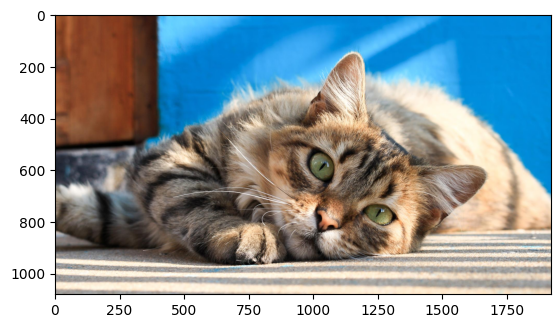

In [54]:
# 이미지 호출
img = cv2.imread("./data/cat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [55]:
# unsqueeze() 예시
import torch

x1 = torch.rand(3, 10, 64)
x2 = x1.unsqueeze(dim=0)
print(x2.shape)

x3 = x1.unsqueeze(dim=1)
print(x3.shape)

torch.Size([1, 3, 10, 64])
torch.Size([3, 1, 10, 64])


In [60]:
x1

tensor([[[6.2484e-01, 8.5212e-01, 3.1529e-01,  ..., 4.9604e-01,
          6.0958e-04, 7.9588e-01],
         [6.8992e-01, 8.3625e-01, 2.0162e-01,  ..., 5.8575e-01,
          3.7882e-01, 9.2166e-01],
         [3.5203e-01, 9.2768e-02, 5.9415e-01,  ..., 5.2734e-01,
          3.1348e-01, 4.9212e-01],
         ...,
         [7.7429e-01, 8.3669e-01, 1.7626e-01,  ..., 1.3090e-01,
          1.0931e-01, 8.3405e-01],
         [3.2394e-01, 2.5160e-01, 9.7488e-01,  ..., 2.8182e-01,
          1.1933e-01, 5.1560e-02],
         [4.8597e-01, 5.0071e-02, 6.2692e-01,  ..., 2.5213e-01,
          8.7011e-01, 7.0779e-01]],

        [[5.4835e-01, 5.1119e-01, 8.7860e-01,  ..., 7.2213e-01,
          9.8841e-01, 9.4724e-01],
         [5.2156e-01, 2.4615e-01, 3.9803e-01,  ..., 7.8036e-02,
          6.4375e-01, 9.6273e-01],
         [4.1662e-01, 2.4917e-01, 7.1231e-01,  ..., 8.7565e-01,
          4.4470e-02, 9.0836e-01],
         ...,
         [9.6308e-01, 5.8978e-01, 4.4380e-01,  ..., 5.9605e-01,
          8.394

In [61]:
x2

tensor([[[[6.2484e-01, 8.5212e-01, 3.1529e-01,  ..., 4.9604e-01,
           6.0958e-04, 7.9588e-01],
          [6.8992e-01, 8.3625e-01, 2.0162e-01,  ..., 5.8575e-01,
           3.7882e-01, 9.2166e-01],
          [3.5203e-01, 9.2768e-02, 5.9415e-01,  ..., 5.2734e-01,
           3.1348e-01, 4.9212e-01],
          ...,
          [7.7429e-01, 8.3669e-01, 1.7626e-01,  ..., 1.3090e-01,
           1.0931e-01, 8.3405e-01],
          [3.2394e-01, 2.5160e-01, 9.7488e-01,  ..., 2.8182e-01,
           1.1933e-01, 5.1560e-02],
          [4.8597e-01, 5.0071e-02, 6.2692e-01,  ..., 2.5213e-01,
           8.7011e-01, 7.0779e-01]],

         [[5.4835e-01, 5.1119e-01, 8.7860e-01,  ..., 7.2213e-01,
           9.8841e-01, 9.4724e-01],
          [5.2156e-01, 2.4615e-01, 3.9803e-01,  ..., 7.8036e-02,
           6.4375e-01, 9.6273e-01],
          [4.1662e-01, 2.4917e-01, 7.1231e-01,  ..., 8.7565e-01,
           4.4470e-02, 9.0836e-01],
          ...,
          [9.6308e-01, 5.8978e-01, 4.4380e-01,  ..., 5.9605

In [62]:
x3

tensor([[[[6.2484e-01, 8.5212e-01, 3.1529e-01,  ..., 4.9604e-01,
           6.0958e-04, 7.9588e-01],
          [6.8992e-01, 8.3625e-01, 2.0162e-01,  ..., 5.8575e-01,
           3.7882e-01, 9.2166e-01],
          [3.5203e-01, 9.2768e-02, 5.9415e-01,  ..., 5.2734e-01,
           3.1348e-01, 4.9212e-01],
          ...,
          [7.7429e-01, 8.3669e-01, 1.7626e-01,  ..., 1.3090e-01,
           1.0931e-01, 8.3405e-01],
          [3.2394e-01, 2.5160e-01, 9.7488e-01,  ..., 2.8182e-01,
           1.1933e-01, 5.1560e-02],
          [4.8597e-01, 5.0071e-02, 6.2692e-01,  ..., 2.5213e-01,
           8.7011e-01, 7.0779e-01]]],


        [[[5.4835e-01, 5.1119e-01, 8.7860e-01,  ..., 7.2213e-01,
           9.8841e-01, 9.4724e-01],
          [5.2156e-01, 2.4615e-01, 3.9803e-01,  ..., 7.8036e-02,
           6.4375e-01, 9.6273e-01],
          [4.1662e-01, 2.4917e-01, 7.1231e-01,  ..., 8.7565e-01,
           4.4470e-02, 9.0836e-01],
          ...,
          [9.6308e-01, 5.8978e-01, 4.4380e-01,  ..., 5.96

In [63]:
# (0): Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0) # 0번 째 Conv2d 특성 맵 확인

model(img)
activations = result.features

C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\778021394.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


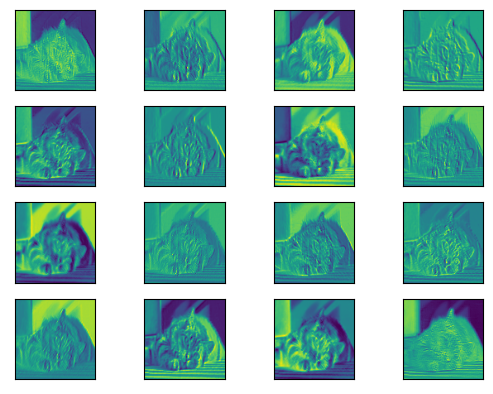

<Figure size 1200x800 with 0 Axes>

In [64]:
# 특성 맵 확인
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [65]:
# 20번 째 계층에 대한 특성 맵
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\778021394.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [66]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.4, inplace=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padd

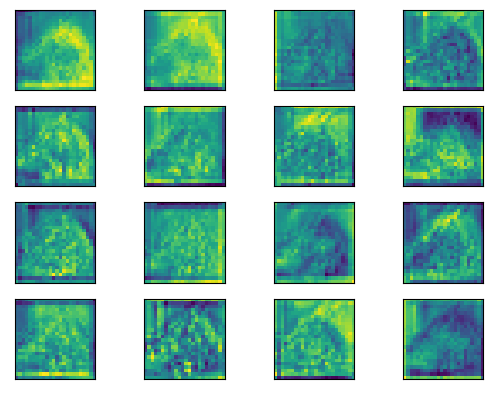

<Figure size 1200x800 with 0 Axes>

In [70]:
# 특성 맵 확인
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [71]:
activations

array([[[[ 2.76882929e-04, -3.87764827e-04, -1.75635563e-04, ...,
           3.73351690e-03,  4.93593654e-03,  2.03896384e-03],
         [ 2.00626766e-03,  2.63231597e-03,  3.03895609e-03, ...,
           6.07387954e-03,  6.61798846e-03,  4.60678106e-03],
         [ 2.38944078e-03,  3.83878732e-03,  3.55110317e-03, ...,
           6.28762599e-03,  6.85772486e-03,  5.81062911e-03],
         ...,
         [ 2.33121635e-03,  6.19992381e-03,  7.90439546e-03, ...,
           1.19577032e-02,  1.25283012e-02,  8.99964105e-03],
         [ 4.33559064e-03,  8.56671948e-03,  9.90561023e-03, ...,
           1.28408726e-02,  1.25264302e-02,  8.92072637e-03],
         [ 3.07245995e-03,  8.24128091e-03,  8.46997276e-03, ...,
           8.99637770e-03,  8.10053386e-03,  6.78637950e-03]],

        [[ 1.61918940e-03,  2.55614868e-03,  3.74815962e-03, ...,
           7.09441304e-03,  7.33707519e-03,  5.24055865e-03],
         [ 2.67086783e-03,  3.66298179e-03,  4.56433278e-03, ...,
           9.37271956e

In [75]:
# 40번 째 계층에 대한 특성 맵
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_3212\778021394.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


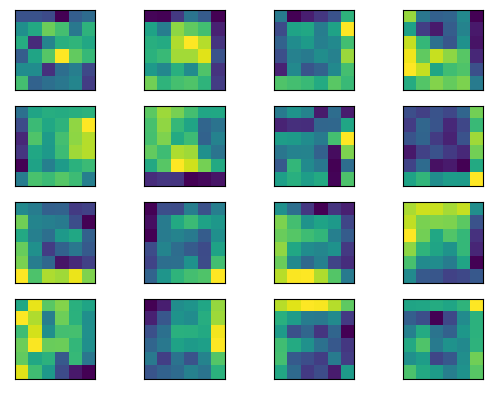

<Figure size 1200x800 with 0 Axes>

In [77]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()